# Package

In [12]:
!pip install fastai -Uqq
!pip install Pillow==9.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
from fastai.vision.all import *

# The Traning Process

### Establishing a Baseline

In [14]:
def get_data(url, presize, resize):
  path = untar_data(url)
  return DataBlock(
      blocks = (ImageBlock, CategoryBlock),
      get_items = get_image_files,
      splitter = GrandparentSplitter(valid_name = 'val'),
      get_y = parent_label,
      item_tfms=Resize(presize),
      batch_tfms=[*aug_transforms(min_scale=0.5, size=resize),
                    Normalize.from_stats(*imagenet_stats)]
  ).dataloaders(path, bs=128)

In [15]:
dls = get_data(URLs.IMAGENETTE_160, 160, 128)

In [16]:
def get_learner(**kwargs):
    return vision_learner(dls, resnet34, pretrained=False,
                    metrics=accuracy, **kwargs).to_fp16()

In [17]:
learn = get_learner()
learn.fit_one_cycle(3, 0.003)

epoch,train_loss,valid_loss,accuracy,time
0,2.575655,1.939530,0.335032,00:27
1,1.995165,1.559690,0.458599,00:27
2,1.621506,1.302536,0.574268,00:28


In [18]:
# using sgd

learn = get_learner(opt_func = SGD)

SuggestedLRs(valley=0.013182567432522774)

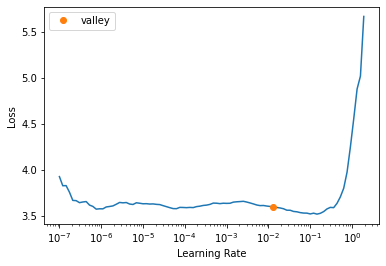

In [19]:
learn.lr_find()

In [20]:
learn.fit_one_cycle(3, 0.03, moms=(0, 0, 0))

epoch,train_loss,valid_loss,accuracy,time
0,2.992437,2.148580,0.280764,00:27
1,2.430845,1.809284,0.394650,00:26
2,2.176307,1.744284,0.419108,00:26


### A Generic Optimizer

In [21]:
def sgd_cb(p, lr, **kwargs): p.data.add_(-lr, p.grad.data)

In [22]:
opt_func = partial(Optimizer, cbs=[sgd_cb])

In [23]:
learn = get_learner(opt_func=opt_func)
learn.fit(3, 0.03)

epoch,train_loss,valid_loss,accuracy,time
0,2.672354,2.027927,0.319490,00:26
1,2.300995,1.755036,0.390064,00:26
2,1.960471,1.563121,0.468280,00:26


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1055.)
  """Entry point for launching an IPython kernel.


### Momentum

In [24]:
x = np.linspace(-4, 4, 100)

In [25]:
y = 1 - (x / 3) ** 2

In [26]:
x1 = x + np.random.randn(100) * 0.1
y1 = y + np.random.randn(100) * 0.1

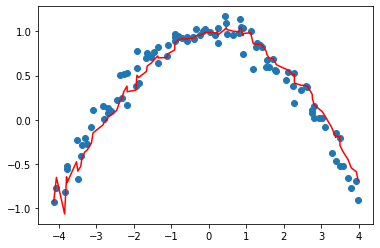

In [27]:
plt.scatter(x1, y1)
idx = x1.argsort()
beta, avg, res = .7, 0, []

for i in idx:
  avg = beta * avg + (1-beta) * y1[i]
  res.append(avg/(1-beta**(i+1)))

plt.plot(x1[idx], np.array(res), color='red');

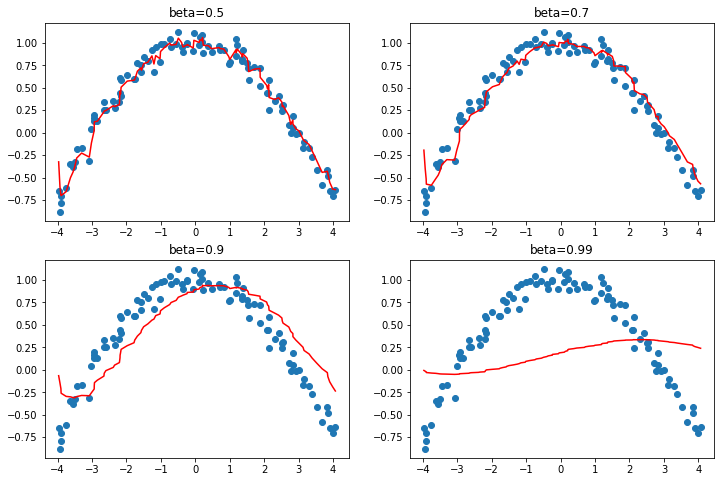

In [28]:
x = np.linspace(-4, 4, 100)
y = 1 - (x/3) ** 2
x1 = x + np.random.randn(100) * 0.1
y1 = y + np.random.randn(100) * 0.1
_,axs = plt.subplots(2,2, figsize=(12,8))
betas = [0.5,0.7,0.9,0.99]
idx = x1.argsort()
for beta,ax in zip(betas, axs.flatten()):
    ax.scatter(x1,y1)
    avg,res = 0,[]
    for i in idx:
        avg = beta * avg + (1-beta) * y1[i]
        res.append(avg)#/(1-beta**(i+1)))
    ax.plot(x1[idx],np.array(res), color='red');
    ax.set_title(f'beta={beta}')


```
weight.avg = beta * weight.avg + (1-beta) * weight.grad
new_weight = weight - lr * weight.avg
```



When an optimizer callback returns a dict, it is used to update the state of the optimizer and is passed back to the optimizer on the next step. So this callback will keep track of the gradient averages in a parameter called grad_avg:



In [29]:
def average_grad(p, mom, grad_avg=None, **kwargs):
  if grad_avg is None: grad_avg = torch.zeros_like(p.grad.data)
  return {'grad_avg': grad_avg * mom + p.grad.data}

In [30]:
def momentum_step(p, lr, grad_avg, **kwargs): 
  p.data.add_(-lr, grad_avg)

In [31]:
opt_func = partial(Optimizer, cbs=[average_grad,momentum_step], mom=0.9)

In [32]:
learn = get_learner(opt_func=opt_func)
learn.fit_one_cycle(3, 0.03)

epoch,train_loss,valid_loss,accuracy,time
0,2.731452,2.057279,0.302930,00:26
1,2.448334,1.833015,0.368408,00:26
2,2.134692,1.721987,0.422675,00:27


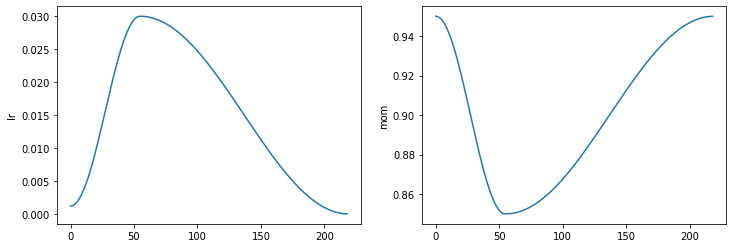

In [33]:
learn.recorder.plot_sched()

### RMSProp

* RMSProp is another variant of SGD
* The main difference from SGD is that it uses an adaptive learning rate: 
* each parameter gets its own specific learning rate controlled by a global learning rate


```That way we can speed up training by giving a higher learning rate to the weights that need to change a lot while the ones that are good enough get a lower learning rate.```

##### How we decide
* We can look at the gradients to get an idea. If a parameter's gradients have been close to zero for a while, that parameter will need a higher learning rate because the loss is flat. 

* On the other hand, if the gradients are all over the place, we should probably be careful and pick a low learning rate to avoid divergence

* Once again, to determine the general tendency behind the noise, we will use a moving average—specifically the moving average of the gradients squared. Then we will update the corresponding weight by using the current gradient (for the direction) divided by the square root of this moving average (that way if it's low, the effective learning rate will be higher, and if it's high, the effective learning rate will be lower

```
w.square_avg = alpha * w.square_avg + (1-alpha) * (w.grad ** 2)
new_w = w - lr * w.grad / math.sqrt(w.square_avg + eps)
```

In [34]:
def average_sqr_grad(p, sqr_mom, sqr_avg = None, **kwargs):
  if sqr_avg is None:
    sqr_avg = torch.zeros_like(p.grad.data)
  return {'sqr_avg': sqr_mom*sqr_avg + (1-sqr_mom) * p.grad.data**2}

In [35]:
def rms_prop_step(p, lr, sqr_avg, eps, grad_avg=None, **kwargs):
    denom = sqr_avg.sqrt().add_(eps)
    p.data.addcdiv_(-lr, p.grad, denom)

opt_func = partial(Optimizer, cbs=[average_sqr_grad,rms_prop_step],
                   sqr_mom=0.99, eps=1e-7)

In [36]:
learn = get_learner(opt_func=opt_func)
learn.fit_one_cycle(3, 0.003)

epoch,train_loss,valid_loss,accuracy,time
0,2.730512,2.444288,0.268280,00:27
1,2.003846,1.747413,0.411465,00:27
2,1.529015,1.227446,0.596433,00:27


### Adam

```
w.avg = beta * w.avg + (1-beta) * w.grad
unbias_avg = w.avg / (1 - (beta**(i+1)))
```

```
w.avg = beta1 * w.avg + (1-beta1) * w.grad
unbias_avg = w.avg / (1 - (beta1**(i+1)))
w.sqr_avg = beta2 * w.sqr_avg + (1-beta2) * (w.grad ** 2)
new_w = w - lr * unbias_avg / sqrt(w.sqr_avg + eps)
```

### Callbacks

#### Creating a Callback

In [38]:
class ModelResetter(Callback):
  def before_train(self):
    self.model.reset()
  def before_validate(self):
    self.model.reset()

In [39]:
class RNNRegularizer(Callback):
    def __init__(self, alpha=0., beta=0.): self.alpha,self.beta = alpha,beta

    def after_pred(self):
        self.raw_out,self.out = self.pred[1],self.pred[2]
        self.learn.pred = self.pred[0]

    def after_loss(self):
        if not self.training: return
        if self.alpha != 0.:
            self.learn.loss += self.alpha * self.out[-1].float().pow(2).mean()
        if self.beta != 0.:
            h = self.raw_out[-1]
            if len(h)>1:
                self.learn.loss += self.beta * (h[:,1:] - h[:,:-1]
                                               ).float().pow(2).mean()

In [40]:
class TerminateOnNaNCallback(Callback):
    run_before=Recorder
    def after_batch(self):
        if torch.isinf(self.loss) or torch.isnan(self.loss):
            raise CancelFitException